Questions to explore

- Are bigger budget movies more highly rated?
- How has movie budgets changed over time? (adjusted for inflation - inflation not in the data) [Maybe 60s-present]

### Import libraries and examine data

In [198]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numpy as np
import ast
%matplotlib inline

In [199]:
movies = pd.read_csv('data/tmdb_5000_movies.csv')

movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [200]:
#Create df to explore in initial exploration
df = movies[['budget','vote_average','vote_count','revenue','release_date','genres','production_companies']].copy()

df.head(2)

,budget,vote_average,vote_count,revenue,release_date,genres,production_companies
0,237000000,7.2,11800,2787965087,2009-12-10,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Ingenious Film Partners"", ""id"": 289..."
1,300000000,6.9,4500,961000000,2007-05-19,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""..."


### Code set aside to possibly be used later

In [205]:
"""
#We'll remove these 320 movies with a budget of above a 100 million dollars.
len(df[df['budget']>=100000000]) 

df=df[df['budget']<100000000]

len(df) #
"""

"\n#We'll remove these 320 movies with a budget of above a 100 million dollars.\nlen(df[df['budget']>=100000000]) \n\ndf=df[df['budget']<100000000]\n\nlen(df) #\n"

In [206]:
"""
#Examine modern movies
#Only 72 movies in our remaining dataset were made before 1960
sum(df['year']<1960)

df = df[df['year']>=1960]
"""

"\n#Examine modern movies\n#Only 72 movies in our remaining dataset were made before 1960\nsum(df['year']<1960)\n\ndf = df[df['year']>=1960]\n"

### Comment #1
I'd probably plot the budget on a log scale because it's a positive quantity with a highly skewed distribution. This may make any trend more visible.

Create log of budget

In [207]:
df['log_budget']=np.log(df['budget']+1)

It appears that the budgets have bimodal distribution - a cluster of movies at 0, and the rest much higher. Distribution of log budgets:

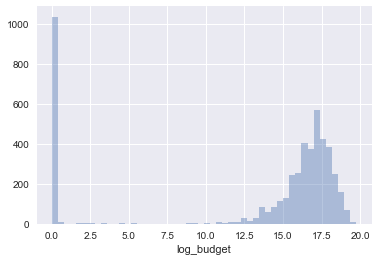

In [208]:
sns.distplot(df['log_budget'],kde=False,bins=50);

Let's examine the films with a budget greater than 0.

In [209]:
positive_budget_df = df[df['budget']>0]

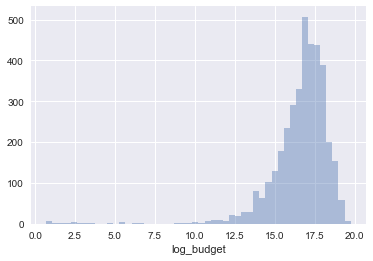

In [210]:
sns.distplot(positive_budget_df['log_budget'],kde=False,bins=50);

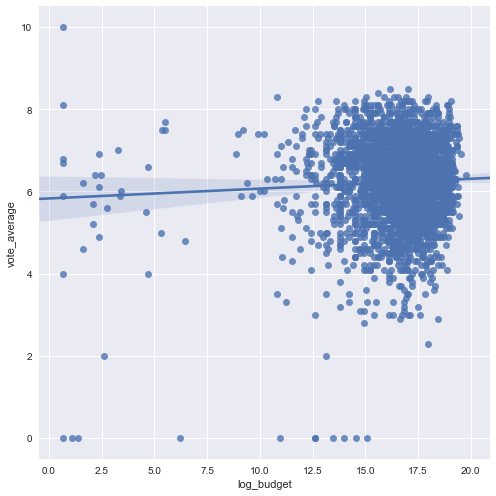

In [211]:
sns.lmplot('log_budget','vote_average',data=positive_budget_df,size=7,);

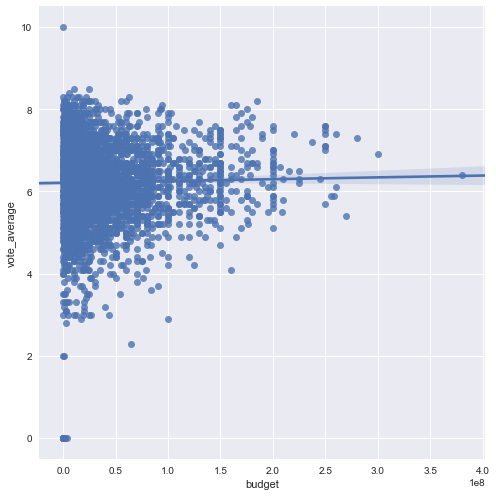

In [212]:
sns.lmplot('budget','vote_average',data=positive_budget_df,size=7,);

#### Question/Note:

I need to study how to interpret log axis plots.

### Comment #2:
In the histogram of vote averages there appears to be regular peaks indicating some popularities are more granular than others. Can you find a way to divide the movies into two classes based on this? It might be that the more discretized popularities come from a different source than the others and may therefore have a different relationship with budget.


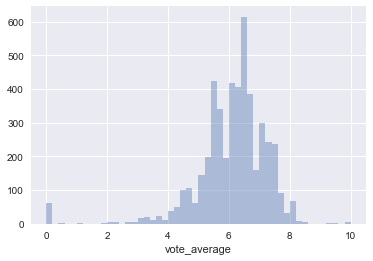

In [213]:
sns.distplot(df['vote_average'],kde=False,bins=50);

#### Question/Note:

I'm not sure where to go from here.

### Comment #3
When there are so many point on the plot it is hard to see where the average vote is. I would be tempted to add a loss fit or to group movies with a similar budget together and plot a boxplot. The latter gives a better idea of the variance. For the scatter plots it looks like the variance in average vote is higher for lower budgets but this could just be because there are many more point giving the impression of a larger spread.


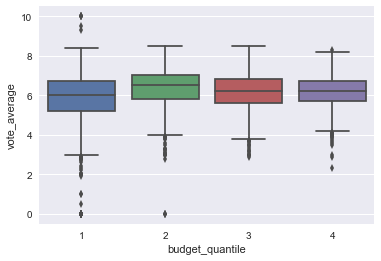

In [214]:
#group movies with a similar budget together and plot a boxplot

df['budget_quantile'] = pd.qcut(x=df['budget'], q=4, labels=[1,2,3,4], retbins=False, precision=3)

sns.boxplot(x='budget_quantile',y='vote_average',data=df);

This does confirm that "variance in average vote is higher for lower budgets."

#### Question/Note:

Not all issues in comment have been addressed.

### Comment #4
I think the Pearson correlation is a good way to summarise the relationship between budget and vote score in a single number.


In [215]:
corr, p_value = stats.pearsonr(df['budget'], df['vote_average'])

print("Correlation: {}".format(corr))
print("With p-value: {}".format(p_value))

Correlation: 0.09314574534816411
With p-value: 9.948784050954314e-11


### Comment #5
A good first step in exploratory analysis is to plot every numeric column against every other, in what's called a "pairs" plot. This plot will quickly show if there are any interesting correlations between the covariates.


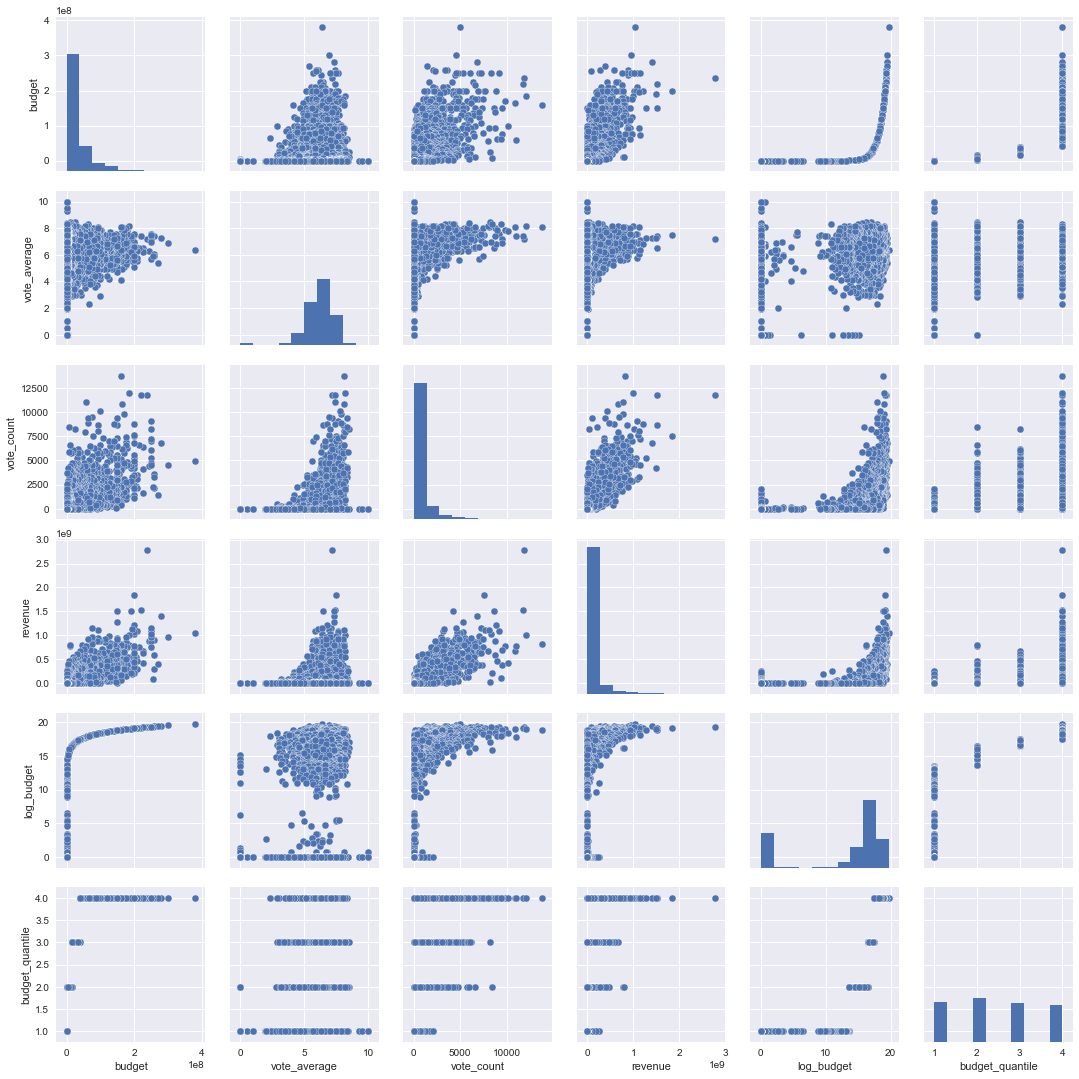

In [216]:
sns.pairplot(df);

### Comment #6
If there is greater variance in votes for low budget films, can you find any other factors that may explain this? E.g. season of release, genre, production company.


#### Self Note:
For this section I need to figure out how to make hue plot for all genre names and production companies (not just the first one listed).

#### Examine genres

In [217]:
#Stored as list of dictionaries with multiple genres per movie
row_1_genres = df['genres'].iloc[0]
row_1_genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [218]:
#Acutally stored as a string! Need to convert to list
type(row_1_genres)

str

In [219]:
#Convert row to list of dictionaries
row_1_genres_as_list = ast.literal_eval(row_1_genres)
row_1_genres_as_list

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [220]:
#Retrieve names
row_1_genre_names = [genre['name'] for genre in row_1_genres_as_list]
row_1_genre_names 

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

Do I want to store each genre in its own column with true/false. Or do I want to store genres as list of names in column.
Currently I'm not sure how to do hue plots with multiple genres per movie. To start, I'll make hue-plot of the first genre listed to see if that generates other ideas.

In [221]:
def extract_vals_from_dict_str(list_of_dict_as_str,key='name'):
    """
    Parameters:
    list_of_dict_as_str = a string which contains a list of dictionaries
    key = key to extract on (default is 'name')
    
    Returns:
    list_of_vals = The the key values as a list
    
    If no values are specified, the list ['None'] is returned
    """
    list_of_dict = ast.literal_eval(list_of_dict_as_str)
    list_of_vals = [item[key] for item in list_of_dict]
    
    if list_of_vals==[]:
        return ['None']
    return list_of_vals

In [222]:
df['first_genre']=df['genres'].apply(lambda x: extract_vals_from_dict_str(x,key='name')[0])

Plot first genre vs. vote average:<br>
Seeking to determine what relationship genre has to vote average.

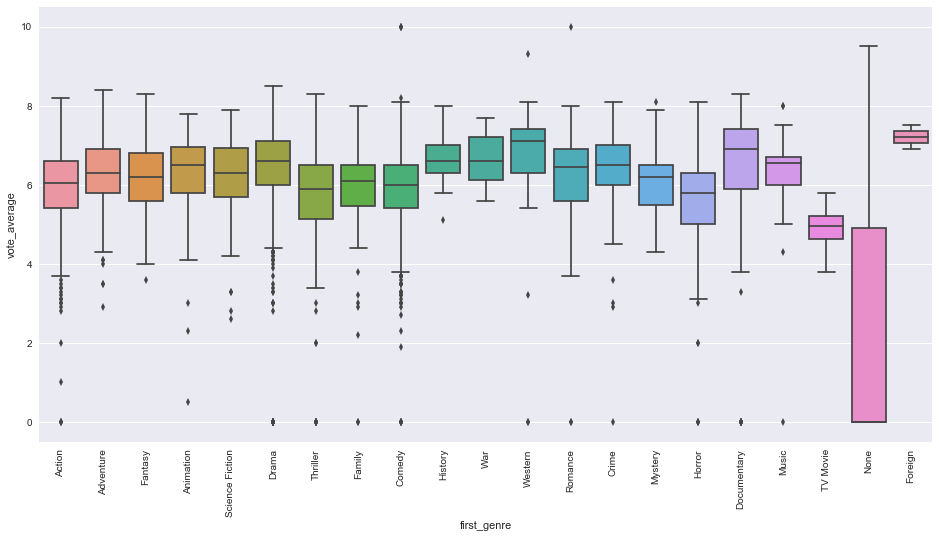

In [288]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
sns.boxplot(x='first_genre',y='vote_average',data=df);

#### Examine production company's affect on vote average

In [224]:
#Like genres, production companies are stored as a str which contains a list of dictionaries
movies['production_companies'].iloc[0]

'[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]'

In [225]:
#We'll reuse the function created above
df['first_production_company']=df['production_companies'].apply(lambda x: extract_vals_from_dict_str(x,key='name')[0])

In [226]:
#Unfortunately there are 1300 unique production companies
df['first_production_company'].nunique()

1314

In [292]:
#We'll look at the 50 production companies who have made the most films
top_producing_companies = df.groupby('first_production_company').count().sort_values(by='production_companies',ascending=False).head(50).index

top_company_df = df[df['first_production_company'].isin(top_producing_companies)]

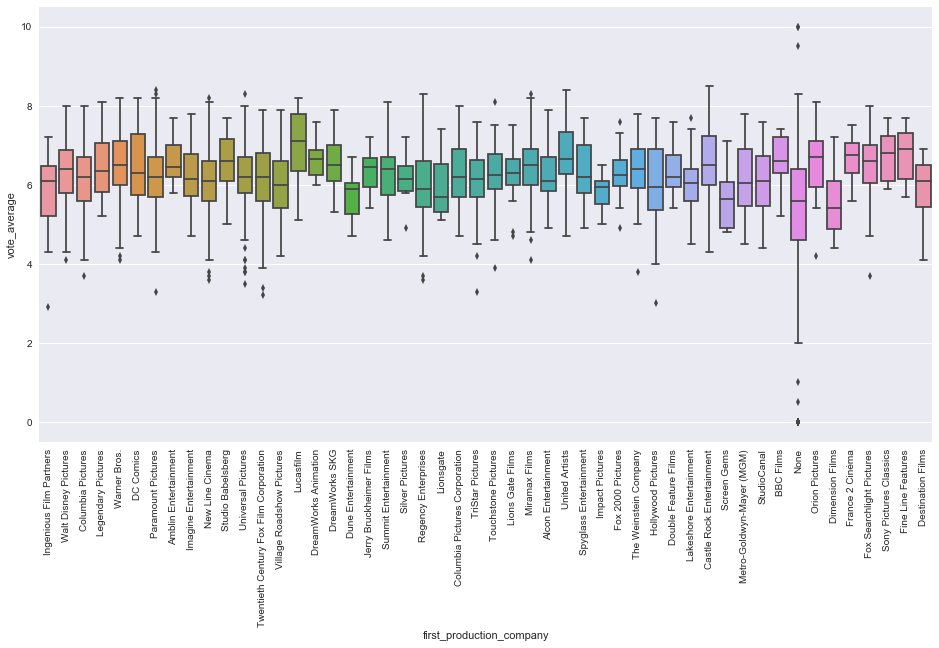

In [293]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
sns.boxplot(x='first_production_company',y='vote_average',data=top_company_df);

#### Examine season/time of release

In [241]:
#Null value in the data
df[df['release_date'].isnull()]

,budget,vote_average,vote_count,revenue,release_date,genres,production_companies,log_budget,budget_quantile,first_genre,first_production_company,year


In [242]:
#Drop columns with null values
df.dropna(axis=0,inplace=True)

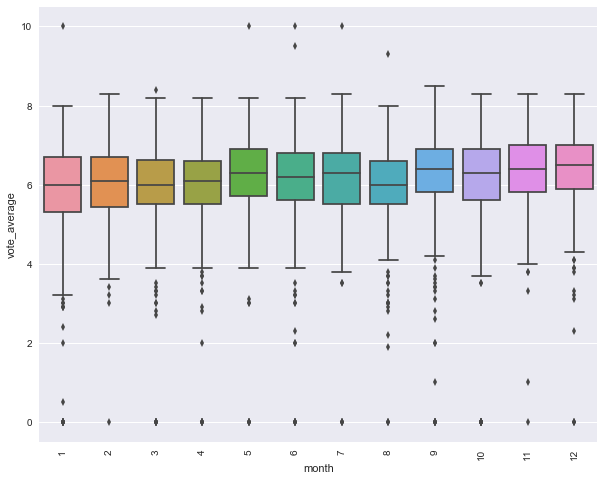

In [272]:
#Examine vote by month
df['month']=df['release_date'].apply(lambda x: int(x.split('-')[1]))

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.boxplot(x='month',y='vote_average',data=df);

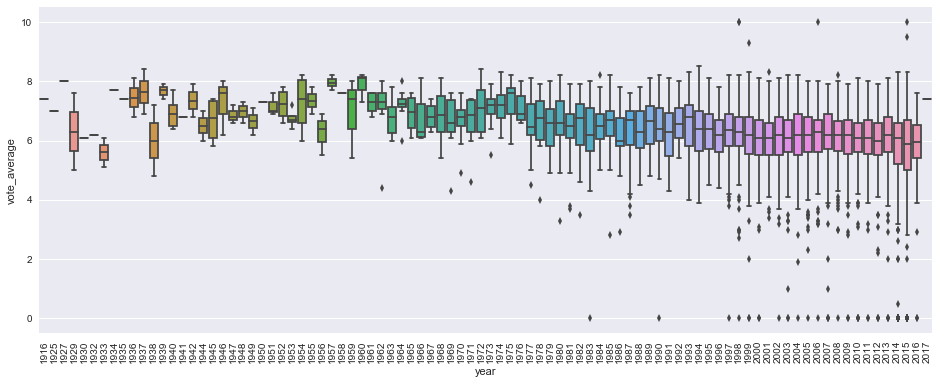

In [250]:
#Examine vote by year
df['year']=df['release_date'].apply(lambda x: int(x.split('-')[0]))

plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.boxplot(x='year',y='vote_average',data=df);

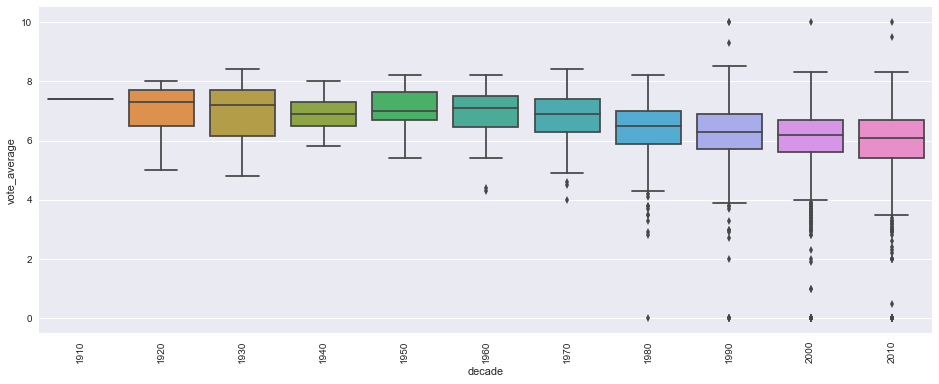

In [276]:
#Examine vote by decde
df['decade'] = df['year'].apply(lambda x: int(str(x)[:3]+'0'))

plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.boxplot(x='decade',y='vote_average',data=df);

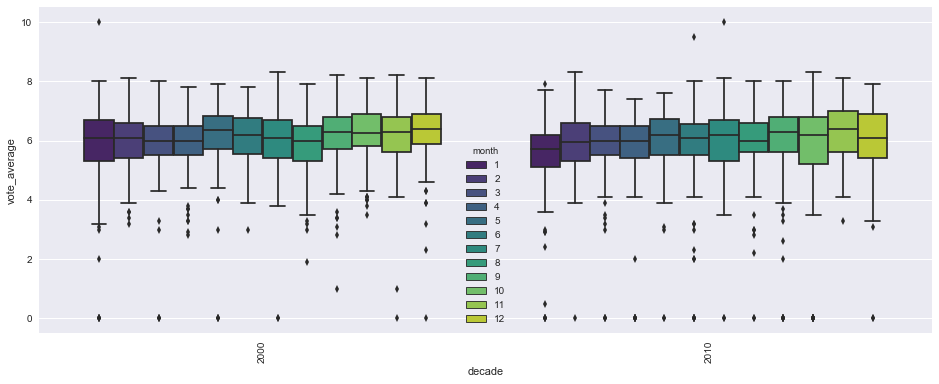

In [286]:
#Examine modern movies (movies made in the 2000s) by decade and month
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.boxplot(x='decade',y='vote_average',hue='month',data=df[df['decade']>=2000],palette='viridis');

### Comment #7
For the time series, again I'd be tempted to try plotting log budget.


#### Plot year vs. log_budget

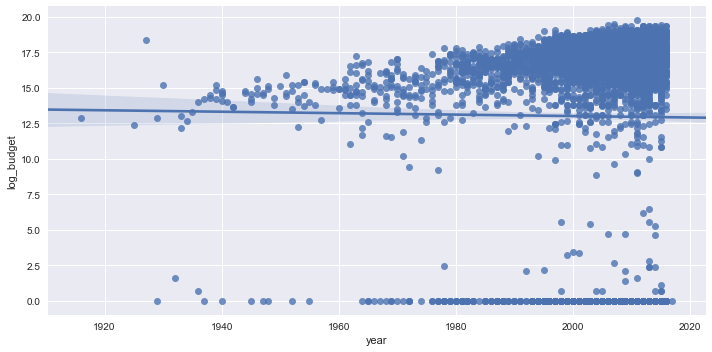

In [24]:
sns.lmplot('year','log_budget',data=df,aspect=2);

#### Plot year vs log_budget of movies with budget greater than 0.

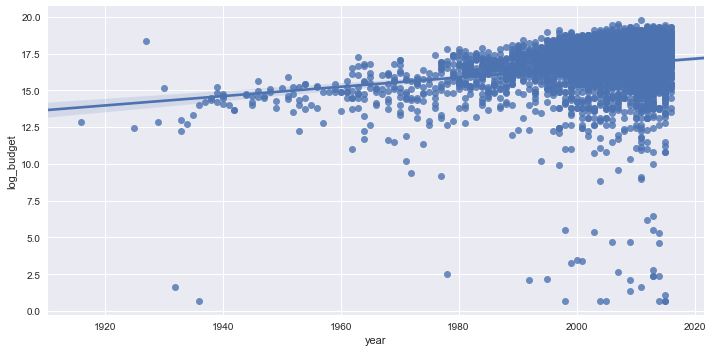

In [32]:
positive_budget_df = df[df['budget']>0]

sns.lmplot('year','log_budget',data=postive_budget_df,aspect=2);

In [33]:
corr, p_value = stats.pearsonr(positive_budget_df['log_budget'],positive_budget_df['year'])

print("Correlation: {}".format(corr))
print("With p-value: {}".format(p_value))

Correlation: 0.20871269331335804
With p-value: 2.4493233867631723e-38


This relationship appears much more linear and has a higher correlation. This relationship could be due to inflation. Next step for this comment would be to adjust for inflation and see if the linear relationship holds.

__For inflation calculation__<br>
(may be lengthier process since data seems to not be stored in csv (consider webscraping inflation calculator page)

http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/<br>

May also include some useful information:<br>
https://www.bls.gov/cpi/#tables 

### Comment #8
When I make an exploratory plot I try to maximise my chance of finding something interesting by using all the plotting tools at my disposal: namely, colour and facets (sub-plots). So, with the time series I would firstly use boxplots because there are too many points, and I would use colour to show one covariate (e.g. season of release because big budget movies are released over the summer and before the awards season, maybe), and I might make sub-plots for each production company. You can play around with different choices for what to show using colour and sub-plots and you might find an interesting relationship.


### Comment #9
Correlation is probably not the best way of describing the relationship in the time series because the distribution doesn't really look like a bivariate normal. Instead, I'd be looking to fit a model with a high R-squared and an estimate of the growth rate of the budget over time.


### Big Picture Comment
I can imagine a data scientist might be given these data with the brief to predict which of next year's movies were likely to make a big profit so that investors could invest accordingly. I think the first thing I would do is plot every relationship I could thing of and at the same time work out the best scale for the covariates (e.g. log for budget) and creating new features (e.g. length of title). Then I would construct a linear model for profit using the features that looked important from the plots. After that I might try a more flexible approach like random forest regression to see if there is much more predictive value to be gained from the data.